# Clustering the Physical Activities for a Subject in the "Moderately Active" Group
Among the 183 subjects, we classified them into three categories based on their daily average steps:
* Inactive: daily average about 1 step.
* Moderately Active: daily average about 4 steps.
* Highly Active: daily average between 7-9 steps

In this notebook, we cluster the activities for a subject in the "Moderately Active" category.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9
import datetime as datetime
from dateutil.parser import parse

## Load and Parse the data into Time Series
The individual subjects data have been extracted and stored in a separated folder. This subject data is stored in a file "medium3.csv".

In [47]:
dateparse = lambda d: parse(d)
df = pd.read_csv("patients_data/analyses/medium3.csv", parse_dates = \
                 ['Datetime'], index_col = "Datetime", date_parser=dateparse)

### What are the unique dates in this subject's timeline? 

In [48]:
np.unique(df.index.date)

array([datetime.date(2016, 3, 17), datetime.date(2016, 3, 18),
       datetime.date(2016, 3, 19), datetime.date(2016, 3, 20),
       datetime.date(2016, 3, 21), datetime.date(2016, 3, 22),
       datetime.date(2016, 3, 23), datetime.date(2016, 3, 24),
       datetime.date(2016, 3, 25), datetime.date(2016, 3, 26),
       datetime.date(2016, 3, 27), datetime.date(2016, 3, 28),
       datetime.date(2016, 3, 29), datetime.date(2016, 3, 30),
       datetime.date(2016, 3, 31), datetime.date(2016, 4, 1),
       datetime.date(2016, 4, 2), datetime.date(2016, 4, 3),
       datetime.date(2016, 4, 4), datetime.date(2016, 4, 5),
       datetime.date(2016, 4, 6), datetime.date(2016, 4, 7),
       datetime.date(2016, 4, 8), datetime.date(2016, 4, 9)], dtype=object)

### What is the earlist time and latest time in the timeline?

In [49]:
print(np.min(df.index))
print ('-' * 10)
print(np.max(df.index))

2016-03-17 13:20:00
----------
2016-04-09 05:13:00


### How many records in total for this patient?

In [50]:
df = df.iloc[:, 2:]
df.shape

(32634, 15)

### In terms of steps, how do the average activities change in a day (0:00-23:00)?

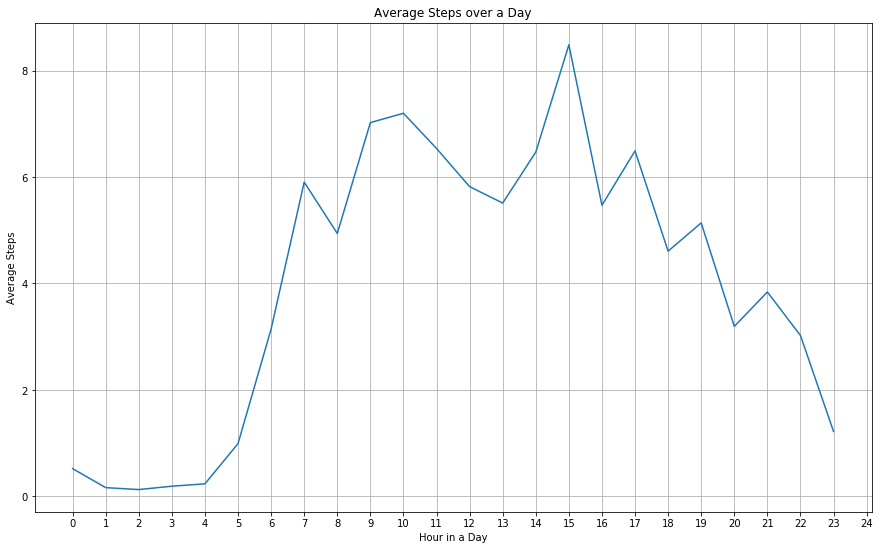

In [51]:
by_time = df[['Steps', 'Hour']].groupby('Hour').mean()
plt.plot(by_time)
plt.title("Average Steps over a Day")
plt.xticks(np.arange(25))
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.grid()

### How do the activity patterns look like in terms of weekdays?

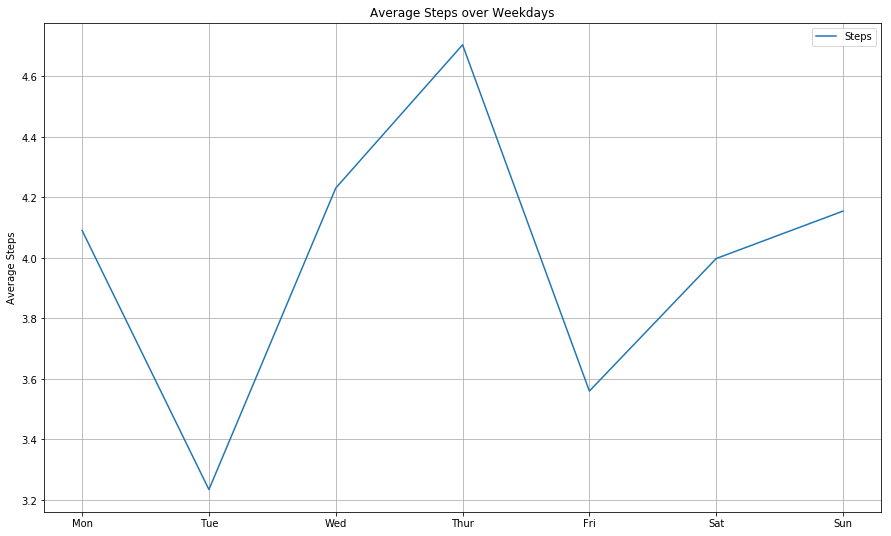

In [52]:
by_weekday = df[['Steps']].groupby(df.index.dayofweek).mean()
xticks = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
by_weekday.index = xticks
by_weekday.plot()
plt.xticks([0,1,2,3,4,5,6], xticks)
plt.ylabel("Average Steps")
plt.title("Average Steps over Weekdays")
plt.grid()

### How do the activity patterns look like in weekdays and weekend?

In [53]:
weekend = np.where(df.index.weekday < 5, 'weekday', 'weekend')
by_time = df.groupby([weekend, 'Hour']).mean()

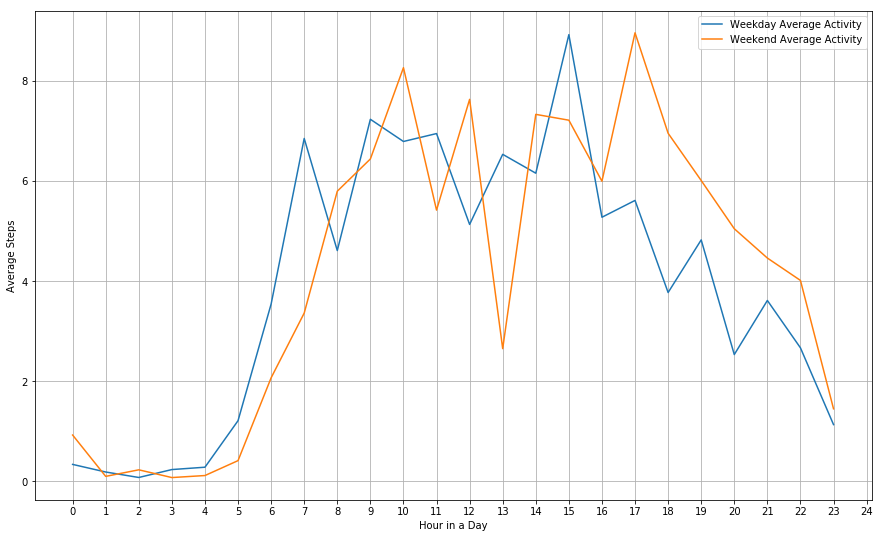

In [54]:
by_time.loc['weekday']['Steps'].plot(label = 'Weekday Average Activity')
by_time.loc['weekend']['Steps'].plot(label = "Weekend Average Activity")
plt.legend()
plt.xlabel("Hour in a Day")
plt.ylabel("Average Steps")
plt.xticks(np.arange(25))
plt.grid()

# Cluster the Activities by 15-minute means

In [55]:
df_15m = df.resample('15T').mean()
df_15m = df_15m[df_15m['WearSens'] == 1]

In [56]:
pd.set_option('display.max_rows', 20)

In [57]:
df_15m.reset_index(inplace = True)

In [58]:
df_15m_data = df_15m[['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU', 'WearSens']]

In [59]:
df_15m_data.shape

(2002, 7)

In [60]:
df_15m_data.index

RangeIndex(start=0, stop=2002, step=1)

In [61]:
df_15m_data = df_15m_data[df_15m_data.WearSens == 1]

In [62]:
df_15m_data.shape

(2002, 7)

In [63]:
df_15m_data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001],
           dtype='int64', length=2002)

In [64]:
df_15m_data = df_15m_data.iloc[:, :-1]
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
0,17.466667,1440.733333,1112.466667,1776.866667,2.162109,2588.584265
1,1.266667,229.200000,223.933333,510.466667,0.172675,612.049012
2,0.866667,302.733333,280.266667,511.400000,0.394139,676.563602
3,0.466667,180.133333,289.133333,251.466667,0.131190,427.248833
4,4.533333,656.066667,688.866667,895.666667,0.850461,1345.300724


In [65]:
df_15m_data.shape

(2002, 6)

In [66]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [67]:
scaler = StandardScaler().fit(df_15m_data)
scaled = scaler.transform(df_15m_data)
scaled.mean(axis = 0)

array([-0., -0.,  0.,  0., -0.,  0.])

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [69]:
hclustering = linkage(scaled, 'ward')

### Cluster the 15-minute mean data into hierarchical clusters. The horizontal line cuts the hierarchical structure into 4 clusters. The numbers at bottom show the number of records in each cluster.

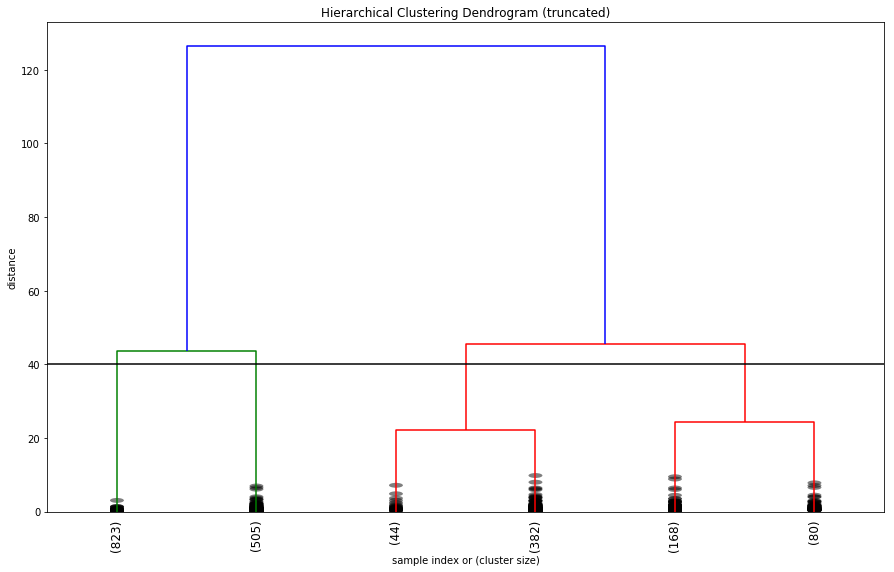

In [70]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    hclustering,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(40, c = 'k')
plt.show()

## Can we cluster the activities into Laying, Sitting, Standing, Walking?

# K-Means Clustering and Visualization

In [71]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

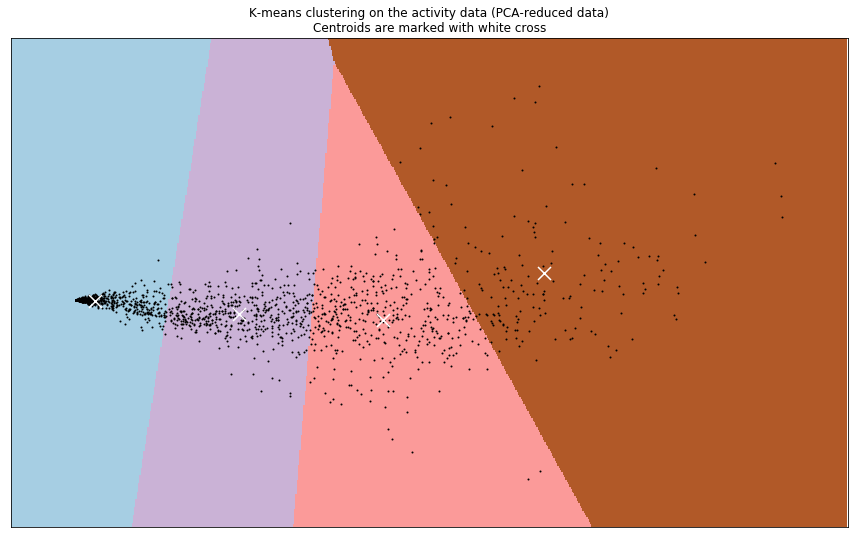

In [72]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(scaled)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the activity data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [73]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [74]:
kmeans.cluster_centers_

array([[-0.63 , -0.807, -0.814, -0.8  , -0.845, -0.852],
       [ 0.615,  1.065,  1.021,  1.   ,  1.156,  1.105],
       [-0.071,  0.148,  0.131,  0.134,  0.112,  0.153],
       [ 2.45 ,  1.801,  1.992,  1.955,  1.909,  1.954]])

In [75]:
pd.value_counts(kmeans.labels_)

0    973
2    471
1    393
3    165
dtype: int64

In [76]:
centers = kmeans.cluster_centers_
scale_centers = scaler.inverse_transform(centers)

In [77]:
np.set_printoptions(precision=3, suppress = True)
scale_centers

array([[   0.405,   99.871,  111.117,  122.242,    0.108,  209.415],
       [   7.537, 1679.154, 1659.081, 1896.627,    2.526, 3221.332],
       [   3.607,  905.665,  908.012, 1043.16 ,    1.265, 1756.871],
       [  18.055, 2300.577, 2478.434, 2838.204,    3.438, 4528.692]])

In [78]:
idx = ['Laying', 'Standing', 'Sitting', 'Walking']
cols = ['Steps', 'YCnt', 'XCnt', 'ZCnt', 'Calories', 'VMU']

In [79]:
clusters = pd.DataFrame(scale_centers, index = idx, columns = cols)

## Let's define the patterns of activities

In [80]:
clusters

,Steps,YCnt,XCnt,ZCnt,Calories,VMU
Laying,0.404865,99.870504,111.116821,122.241795,0.108139,209.415421
Standing,7.537065,1679.154029,1659.081425,1896.626972,2.526277,3221.332359
Sitting,3.607077,905.665110,908.012173,1043.160226,1.264856,1756.871056
Walking,18.054949,2300.576566,2478.433939,2838.203636,3.437573,4528.691612


In [81]:
df_15m_data['label'] = kmeans.labels_
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label
0,17.466667,1440.733333,1112.466667,1776.866667,2.162109,2588.584265,1
1,1.266667,229.200000,223.933333,510.466667,0.172675,612.049012,0
2,0.866667,302.733333,280.266667,511.400000,0.394139,676.563602,0
3,0.466667,180.133333,289.133333,251.466667,0.131190,427.248833,0
4,4.533333,656.066667,688.866667,895.666667,0.850461,1345.300724,2


In [83]:
lab_act = {0:'Laying', 1:'Standing', 2:'Sitting', 3:'Walking'}
df_15m_data['activity'] = df_15m_data['label'].map(lab_act)

In [84]:
df_15m_data.head()

,Steps,YCnt,XCnt,ZCnt,Calories,VMU,label,activity
0,17.466667,1440.733333,1112.466667,1776.866667,2.162109,2588.584265,1,Standing
1,1.266667,229.200000,223.933333,510.466667,0.172675,612.049012,0,Laying
2,0.866667,302.733333,280.266667,511.400000,0.394139,676.563602,0,Laying
3,0.466667,180.133333,289.133333,251.466667,0.131190,427.248833,0,Laying
4,4.533333,656.066667,688.866667,895.666667,0.850461,1345.300724,2,Sitting


In [85]:
df_15m['activity'] = df_15m_data['activity']
df_15m.head()

,Datetime,Day,Week,Hour,Minute,Steps,Lux,YCnt,XCnt,ZCnt,Calories,VMU,Wear,WearSens,activity
0,2016-03-17 16:00:00,1.0,1.0,16.0,7.0,17.466667,0.0,1440.733333,1112.466667,1776.866667,2.162109,2588.584265,1.0,1.0,Standing
1,2016-03-17 16:15:00,1.0,1.0,16.0,22.0,1.266667,2.4,229.200000,223.933333,510.466667,0.172675,612.049012,1.0,1.0,Laying
2,2016-03-17 16:30:00,1.0,1.0,16.0,37.0,0.866667,0.0,302.733333,280.266667,511.400000,0.394139,676.563602,1.0,1.0,Laying
3,2016-03-17 18:00:00,1.0,1.0,18.0,7.0,0.466667,0.0,180.133333,289.133333,251.466667,0.131190,427.248833,1.0,1.0,Laying
4,2016-03-17 18:15:00,1.0,1.0,18.0,22.0,4.533333,0.0,656.066667,688.866667,895.666667,0.850461,1345.300724,1.0,1.0,Sitting


## Visualize the activity patterns 

In [86]:
act_groups = df_15m.groupby(['Hour', 'activity']).count()[['Steps']]

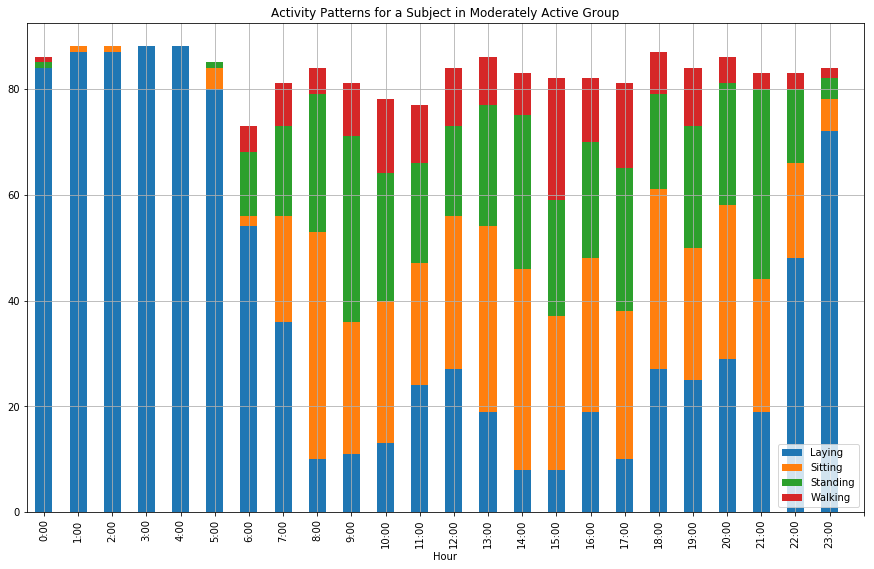

In [88]:
act_groups.unstack()['Steps'].plot(kind = "bar", stacked = True)
plt.xticks(np.arange(25), ['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', \
                          '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', \
                          '21:00', '22:00', '23:00'])
plt.title("Activity Patterns for a Subject in Moderately Active Group")
plt.legend(loc='best')
plt.grid()